# 08. Milestone PyTorch Paper Replicating 

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) architecture/paper with PyTorch.

See ground truth notebook [here](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

## 0. Get setup

Let's import code we're previously written + required libraries.

In [1]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('2.0.1+cu117', '0.15.2+cu117')

In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine

In [3]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steat, susui images we've been using so far.

In [4]:
from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [6]:
from going_modular import data_setup


# Create image size
IMG_SIZE = 224  # comes from tabel 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(F"Manually creaded transform {manual_transforms}")

Manually creaded transform Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize*!

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

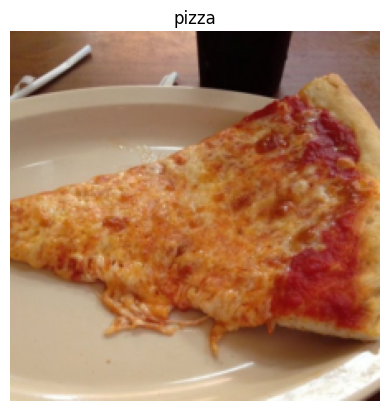

In [9]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # [channel, height, width] -> [height, width, channel]
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at a whole mechine learning paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs**: What goes into the model? (in our case, image tensors)
* **Outputs**: What comes out of model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers**: Take an input, manipulate it with a function (for example could be self-attention).
* **Block**: A collection of layers.
* **Model**: A collection of blocks.

### 3.1 ViT overview: pieces of puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: Different hyperparameters for the architecture/training.
* Text

### Figure 1

<img src="ViT images\08-vit-paper-figure-1-architecture-overview.png" width="600" alt="figure 1 from vision transformer paper">

* Embedding = label represtation (start with random numbers and improve over time)

### Four equations

<img src="ViT images\08-vit-paper-four-equations.png" width="600" alt="four equations from vision transformer paper">

#### Section 3.1 describe various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudo code:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_pathc_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudo code:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_input_MSA_block
```

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}(\mathrm{Eq} .4)$. Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multiplayer perceptron = a neural network with X number of layers 
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudo code:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### Table 1/3

<img src="ViT images\08-vit-paper-table-1.png" width="600" alt="table 1 from vision transformer paper">

* ViT-Base, ViT-Large, ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the numbers of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

## 4. Equation 1: Split dat into patches and creating the class, position and patch embedding

Layer = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width , color_channel)

* Output shape: ???

### 4.1 Calculate input and output shapes by hand

>**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

>**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H \times{W} \times{C}$ (height x width x channels)
* Output shape: $N \times{P^{2}} \cdot C$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / $p^2$ 
* D = constant latent vector size = embedding dimension (see Table 1)

In [10]:
# Create example values
height = 224 
width = 224 
color_channel = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [13]:
# Input shape
embedding_layer_input_shape = (height, width, color_channel)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channel)

print(F"Input shape (single 2D image): {embedding_layer_input_shape}")
print(F"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

Let's *visualize, visualize, visualize!*

(-0.5, 223.5, 223.5, -0.5)

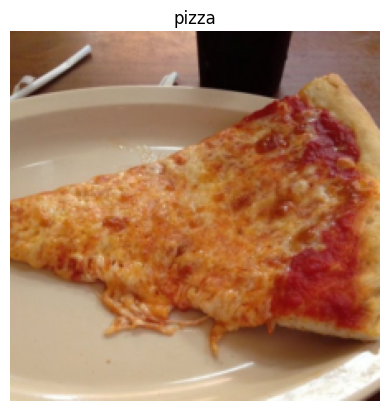

In [12]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

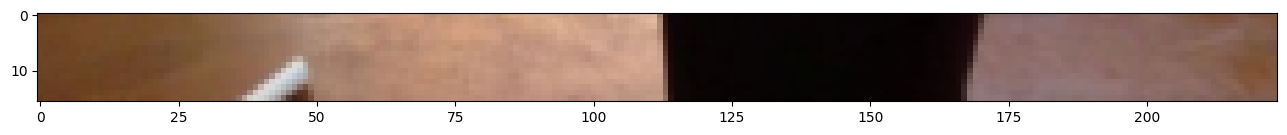

In [14]:
# Get the top row of the image
image_permute = image.permute(1, 2, 0)  # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permute[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


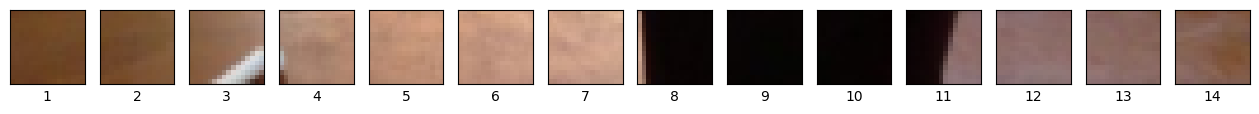

In [30]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisiable by patch size"
print(F"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,  # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permute[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i+1)  # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Totoal patches: 196.0
Patch size: 16 pixels x 16 x pixels


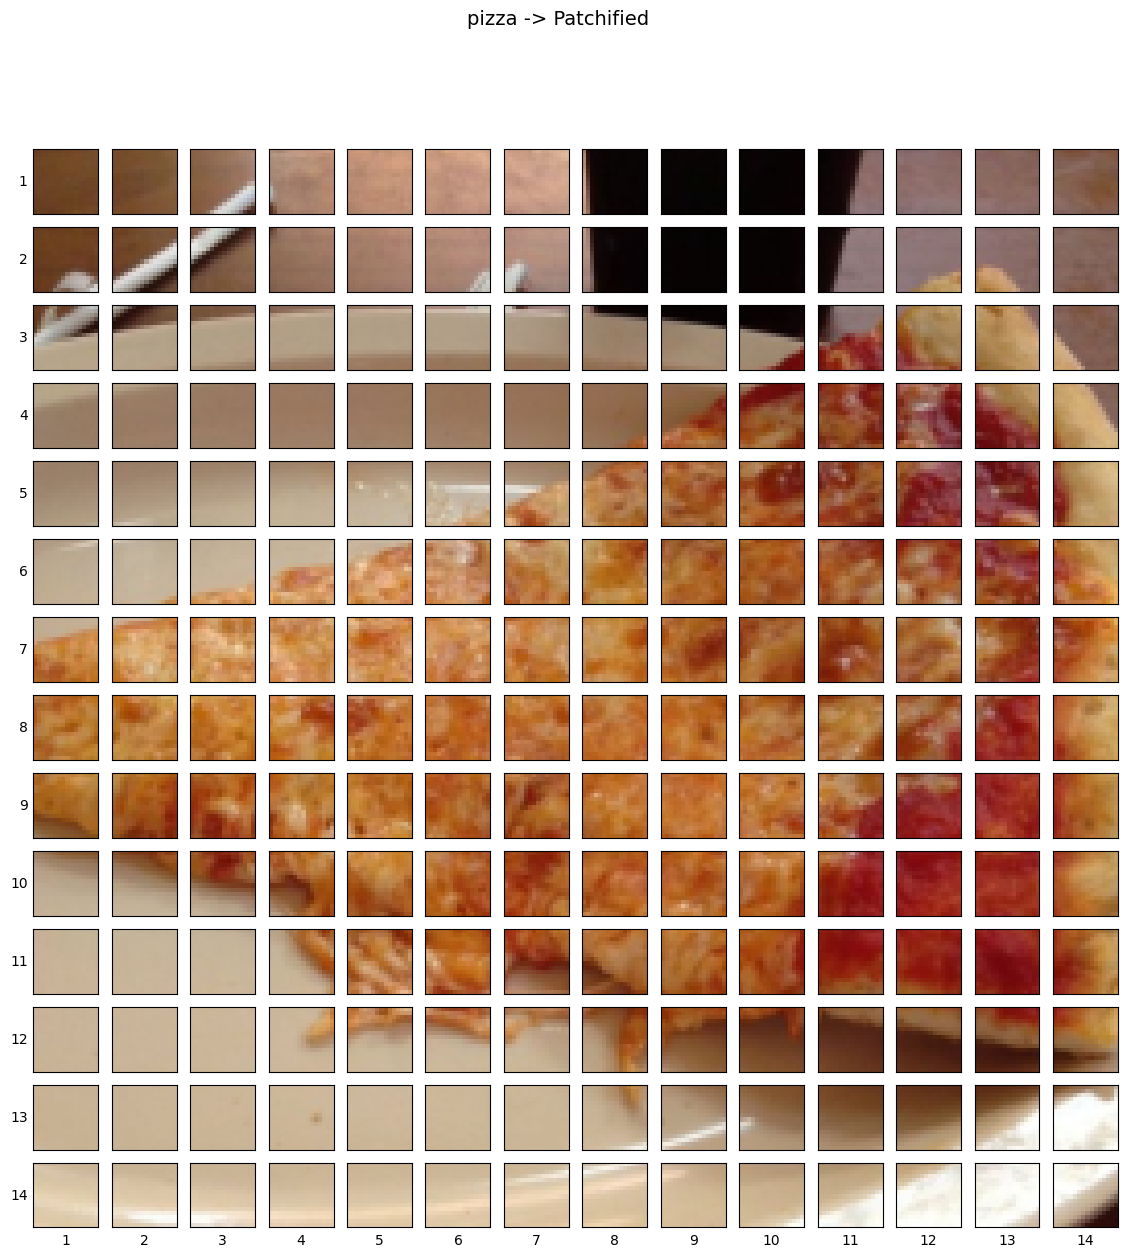

In [36]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch size"
print(F"Number of patches per row: {num_patches}")
print(F"Number of patches per column: {num_patches}")
print(F"Totoal patches: {num_patches * num_patches}")
print(F"Patch size: {patch_size} pixels x {patch_size} x pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows= img_size // patch_size,
                        ncols= img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):  # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permute[patch_height:patch_height+patch_size,  # iterate through height
                                       patch_width:patch_width+patch_size,  # iterate through width
                                       :])  # get all color channels
        # Setup label information for each subplot (patch)
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Setup the title for the plot
fig.suptitle(F"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride values to `patch_size`.

In [37]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn


# Set the patch size
patch_size = 16

# Create conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,  # for color channels
                   out_channels=768,  # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

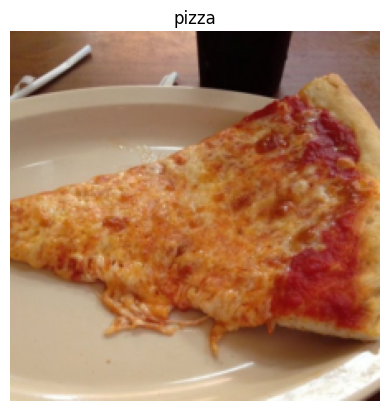

In [38]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [39]:
# Pass image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension -> (batch_size, C, H, W)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])
